In [107]:
import xarray as xr
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

'''
Le script est pour tester la méthode Rayleigh Fit à un jour de données Opar.
Appliquer sur tous les profils, non ou ayant average time. 

La méthode de Rayleigh Fit change au niveau de calcul l'épaisseur d'optique. On change les bornes de l'intégration, sépararer l'intégration en fonction de l'altitude référence. 

'''

def range_corrected_signal(signal_raw, opar_range, opar_alt, bck_correction = False):
    '''
    Fontionc permet de retrouver un signal corrigé de la distance à l'instrument et du fond ciel 
    Input: 
        signal_raw: raw signal (MHz) without any correction
        opar_range: range in meters 
        opar_alt: altitude in meters
        bck_correction: False = non corriger, True = corriger
    Output:
        Signal corrigé 
    '''
    if bck_correction == False:
        rcs = signal_raw * (opar_range**2) #MHz.m^2
    else:
        idx = ((opar_alt>=80000)&(opar_alt<=100000))
        signal_bck = signal_raw.isel(range=idx)
        bck = signal_bck.mean(("range"))
        rcs = (signal_raw - bck)*(opar_range**2)
    return rcs



def get_altitude_reference(zbottom, ztop, altitude_total):
    '''
    Fonction permet de retrouver la position de l'altitude référence dans le vecteur de l'altitude et la valeur de altitude référence.
    Input:
        zbottom: le borne bas de l'intervale
        ztop: le borne haut de l'intervale
        altitude_total: le vecteur total de l'altitude
    Output:
        la valeur de l'altitude et son indexe dans le vecteur total
    '''
    def arg_median(a):
        '''
        Fonction permet de retrouver la position médiane de la zone de référence de l'altitude
        Input: 
            a = l'intervale de l'altitude où se trouve la zone de référence 
        Ouput:
            Indexe de la position dans cet intervale
        '''
        if len(a) % 2 == 1:
            return np.where(a == np.median(a))[0][0]
        else:
            l,r = len(a) // 2 - 1, len(a) // 2
            left = np.partition(a, l)[l]
            right = np.partition(a, r)[r]
            return np.where(a == left)[0][0]

    interval_ref = altitude_total[(altitude_total >= zbottom) & (altitude_total <= ztop)] 
    idxref = arg_median(interval_ref)
    zref = interval_ref[idxref]
    idxref_in_total = np.where(altitude_total == zref)[0][0]
    return zref, idxref_in_total
    
    
### Fonction de simulation
def get_attenuation(p, T, idxref, altitude_total,w):
    '''
    Fonction permet de retrouver l'atténuation du coef en fonction de l'altitude, centré autour de l'altitude de référence
    Méthode est de séparer numériquement la série de l'altitude par rapport à celle de référence (inférieur et supérieur) 
    Input:
        idxref: Indexe de la position de l'altitude référence
        alphamol: vecteur de coef. d'extinction moléculaire
        betamol: vecteur de coef. de backscatter moléculaire
    Output: 
        attnC:  vecteur de backscatter moléculaire atténué
    '''
    def get_backscatter_mol(p, T):
        '''
        Fonction permet de calculer le coef. de backscatter moléculaire 
        p(hPa), T(K), w(um)
        '''
        k = 1.38e-23
        betamol = p/(k*T) * 5.45e-32 * (w/0.55)**(-4.09)
        alphamol = betamol/0.119
        return alphamol, betamol
    
    alphamol, betamol = get_backscatter_mol(p, T)
    print(f'avant: {betamol}')
    
    def Attn_by_RF(alphamol, betamol, idxref, altitude_total):
        C = [0]*len(altitude_total)
        C[idxref] = 0
        # ___z de 0 à zref : index = [0, idxref]
        for i in range(idxref-1, 0, -1):
#             C[i] = C[i-1] - alphamol[i-1]*(opalt[i]-opalt[i-1])
            C[i] = alphamol[i]*(altitude_total[i+1]-altitude_total[idxref]) +C[i+1]

        #___z de zref à fin de l'altitude: index = [idxref,len(alt)]
        for i in range(idxref+1, len(altitude_total)):
            C[i] = alphamol[i]*(altitude_total[i]-altitude_total[idxref]) +C[i-1] 
        
        return np.array(C)
    
    def Attn_from_0(alphamol, betamol, idxref, altitude_total):
        C = [0]*len(altitude_total)
        for i in range(1,len(altitude_total)):
            C[i] = C[i-1] + alphamol[i]*(altitude_total[i]-altitude_total[i-1])
            
        return np.array(C)
    
    C1 = Attn_by_RF(alphamol, betamol, idxref, altitude_total)
    C3 = Attn_from_0(alphamol, betamol, idxref, altitude_total)
    attnC1 = betamol*np.exp(-2*C1)
    attnC3 = betamol*np.exp(-2*C3)
    print(f'apres--------')
    return betamol, attnC1, C1, attnC3, C3


### Normaliser le signal avec le backscatter moléculaire atténué
def normalisation(min_bounds, max_bounds, altitude_total, rcs, attn_mol_bsc):
    '''
    Calculer le constant de calibration en préciser la zone de référence 
    Normaliser le signal par rapport à au constant de calibration
    '''
    idx = (altitude_total >= min_bounds) & (altitude_total <= max_bounds)
    alt_ref = altitude_total[idx]
    rcs_ref = np.mean(rcs[idx])
    attn_mol_bsc_ref = np.mean(attn_mol_bsc[idx])
    Const = attn_mol_bsc_ref/rcs_ref
    print(Const)
    rcs_norm = rcs*Const
    return rcs_norm, Const



In [28]:

### Lire et sortir des données brutes: range(km), channel, signal     
oparpath = Path('/home/nmpnguyen/OPAR/LIO3T.daily/2019-01-24.nc4')
opar = xr.open_dataset(oparpath)
opalt = opar['range'].values*1e3 + 2160
print(opar['channel'])
oparraw = opar.sel(channel='00532.p')#.isel(time=100)
oparraw2 = opar.sel(channel='00532.p')+opar.sel(channel='00532.s')

# oparraw = opar.sel(channel='00355.o.Verylow')
# oparraw2 = opar.sel(channel='00355.o.Low')
    
### Range corrected signal 
rep1 = range_corrected_signal(oparraw, opar['range'].values*1e3, opar['range'].values*1e3+2160, True)
rep2 = range_corrected_signal(oparraw2, opar['range'].values*1e3, opar['range'].values*1e3+2160, True)


### Lire et sortir la Pression et la Temperature  
oparsimulpath = Path('/homedata/nmpnguyen/OPAR/Processed/LIO3T/2019-01-24_simul.pkl')
oparsimul = pd.read_pickle(oparsimulpath)
pression = oparsimul['pression'].unstack(level=1)
ta = oparsimul['ta'].unstack(level=1)

opalt = opalt[:pression.shape[1]]   

<xarray.DataArray 'channel' (channel: 9)>
array(['00289.o', '00289.o', '00316.o', '00316.o', '00532.o', '00532.o',
       '00532.p', '00532.s', '00607.o'], dtype=object)
Coordinates:
  * channel  (channel) object '00289.o' '00289.o' ... '00532.s' '00607.o'


In [84]:
zbottom = 5500
ztop = 7500
Zref, idx_ref = get_altitude_reference(zbottom, ztop, opalt)
t=30
d = rep2.isel(time = t)['signal'][:len(opalt)]
pres = pression.iloc[t,:].values
temp = ta.iloc[t,:].values

attn_bscmol, bscmol = get_attenuation(pres*1e-2, temp, idx_ref, opalt, 0.532)
# print(attn_bscmol)
# print(bscmol)
d_norm, K = normalisation(zbottom, ztop, opalt, d, attn_bscmol)
d_norm_noattn, K_noattn = normalisation(zbottom, ztop, opalt, d, bscmol)
sr = d_norm/attn_bscmol
sr_noattn = d_norm_noattn/bscmol


avant: [1.2389445883912737e-08 1.2380264311155573e-08 1.237108019550609e-08 ...
 1.1063157530064866e-09 1.1052614653906284e-09 1.1042073773912557e-09]
apres: [1.         1.0009024  1.00180338 ... 0.4423685  0.44221611 0.44206386]
<xarray.DataArray 'signal' ()>
array(4.67123961e-19)
Coordinates:
    time     datetime64[ns] 2019-01-24T18:34:18
<xarray.DataArray 'signal' ()>
array(-5.16539842e-12)
Coordinates:
    time     datetime64[ns] 2019-01-24T18:34:18


-------OUTPUT PLOT-------


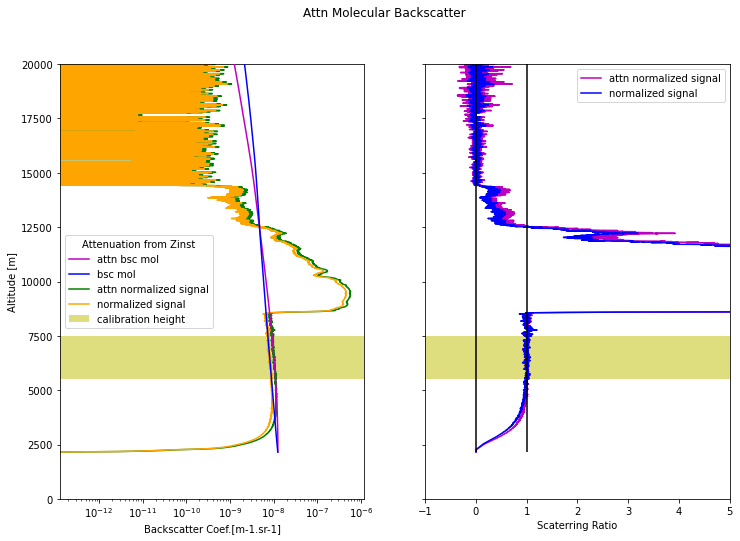

In [69]:
print('-------OUTPUT PLOT-------')
fig, (ax,ax2) = plt.subplots(nrows=1, ncols=2, figsize=[12,8], sharey=True)
ax.plot(attn_bscmol, opalt, label='attn bsc mol', zorder=10, color='m')
ax.plot(bscmol, opalt, label='bsc mol', zorder=10, color='b')
ax.semilogx(d_norm[:len(opalt)], opalt, label='attn normalized signal', color='g')
ax.semilogx(d_norm_noattn[:len(opalt)], opalt, label='normalized signal', color='orange')
ax.axhspan(zbottom, ztop, color='y', alpha=0.5, lw=0, label='calibration height')
ax.set(xlabel='Backscatter Coef.[m-1.sr-1]', ylabel='Altitude [m]')
leg = ax.legend()
leg.set_title('Attenuation from Zinst')
ax.set_ylim(0, 20000)
ax2.plot(sr, opalt, label='attn normalized signal', color='m') 
ax2.plot(sr_noattn, opalt, label='normalized signal', color='b') 
ax2.legend()
ax2.set_ylim(0, 20000)
ax2.vlines(1, ymin=opalt.min(), ymax=opalt.max(), color='k', zorder = 10)
ax2.vlines(0, ymin=opalt.min(), ymax=opalt.max(), color='k', zorder = 10)
ax2.axhspan(zbottom, ztop, color='y', alpha=0.5, lw=0, label='calibration height')
ax2.set(xlabel='Scaterring Ratio')
ax2.set_xlim(-1, 5)
plt.suptitle('Attn Molecular Backscatter')
plt.savefig('AttnZinst_'+str(opar['time'][t].values)+'.png')

In [54]:
print(pres)
print(temp)

[78998.43774222852 78928.87323609376 78859.308729959 ... 5301.696509310496
 5297.106438477466 5292.516367644438]
[288.44276225263013 288.3983637404407 288.35396522825124 ...
 218.13325824863549 218.14013880776082 218.14701936688616]


avant: [1.2389445883912737e-08 1.2380264311155573e-08 1.237108019550609e-08 ...
 1.1063157530064866e-09 1.1052614653906284e-09 1.1042073773912557e-09]
apres--------
13410.0


Text(0.5, 0.98, 'at z=13410.0 m')

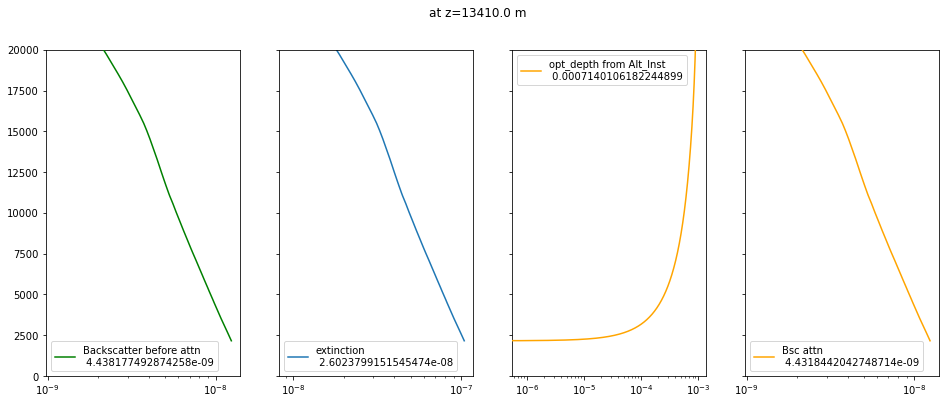

In [113]:
bscmol, attn_bscmol1, tau1, attn_bscmol3, tau3 = get_attenuation(pres*1e-2, temp, idx_ref, opalt, 0.532)
print(opalt[1500])

fig, (ax,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4, figsize=[16,6], sharey=True)
# ax.semilogx(tau1, opalt, label='opt_depth from Alt_ref', zorder=10, color='b')
ax2.semilogx(bscmol/0.119, opalt, label=f'extinction\n {bscmol[2000]/0.119}')
ax3.semilogx(tau3, opalt, label=f'opt_depth from Alt_Inst\n {tau3[1500]}', zorder=10, color='orange')
# ax.axhspan(zbottom, ztop, color='y', alpha=0.5, lw=0, label='calibration height')
ax.set_ylim(0, 20000)
ax.semilogx(bscmol, opalt, label=f'Backscatter before attn\n {bscmol[1500]}', zorder=10, color='g')
# ax2.semilogx(attn_bscmol1, opalt, label='exp:opt_depth from Alt_ref', zorder=10, color='b')
ax4.semilogx(attn_bscmol3, opalt, label=f'Bsc attn\n {attn_bscmol3[1500]}', zorder=10, color='orange')
ax.legend()
ax2.legend()
ax3.legend()
ax4.legend()
plt.suptitle(f'at z={opalt[1500]} m')

In [ ]:
### LE RESIDUE À TESTER
residual = d_norm - attn_bscmol
fig, ax = plt.subplots()
ax.plot(residual, opalt)
ax.set_xlim(-0.2e-8, 0.2e-8)

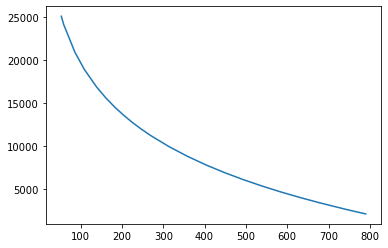

In [115]:
(0)

### Vertically average 

In [70]:

d = rep2.isel(time = t)['signal']
print(len(opalt))
n = 6; s = 3054
d30 = np.mean(d[:s].values.reshape(-1, n), axis=1)
z30 = np.mean(opalt[:s].reshape(-1, n), axis=1)
pres30 = np.mean(pres[:s].reshape(-1, n), axis=1)
temp30 = np.mean(temp[:s].reshape(-1, n), axis=1)#ta.iloc[t,:].values
attn_bscmol30 = np.mean(attn_bscmol[:s].reshape(-1, n), axis=1)
print(len(pres))

3054
3054


In [76]:
d30_norm = normalisation(zbottom, ztop, z30, d30, attn_bscmol30)[0]
sr30 = d30_norm/attn_bscmol30
len(opalt)
print(pres.shape)

4.6709487208491215e-19
(3054,)


-------OUTPUT PLOT-------


(-1.0, 5.0)

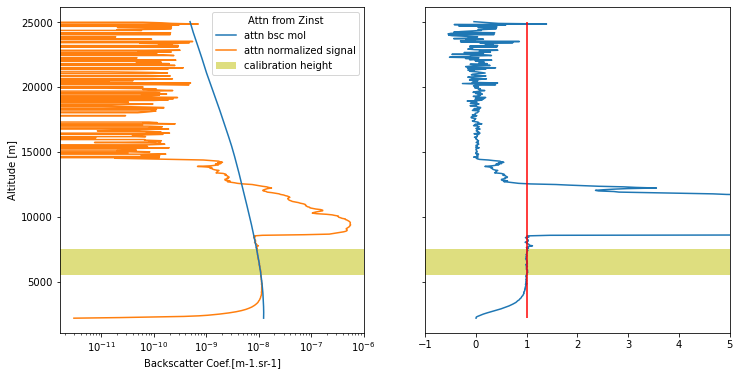

In [79]:
print('-------OUTPUT PLOT-------')
fig, (ax,ax2) = plt.subplots(nrows=1, ncols=2, figsize=[12,6], sharey=True)
ax.semilogx(attn_bscmol30, z30, label='attn bsc mol', zorder=10)
ax.semilogx(d30_norm, z30, label='attn normalized signal')
ax.axhspan(zbottom, ztop, color='y', alpha=0.5, lw=0, label='calibration height')
ax.set(xlabel='Backscatter Coef.[m-1.sr-1]', ylabel='Altitude [m]')
leg = ax.legend()
leg.set_title('Attn from Zinst')
# ax.set_ylim(0, 20000)
# ax.set_xlim(1e-9, 1e-7)
ax2.plot(sr30, z30) 
# ax2.set_ylim(0, 20000)
ax2.vlines(1, ymin=z30.min(), ymax=z30.max(), color='r', zorder = 10)
ax2.axhspan(zbottom, ztop, color='y', alpha=0.5, lw=0, label='calibration height')
ax2.set_xlim(-1,5)


### Horizotally Average

In [379]:
### Average des données 
time_to_average = '30min'
oparrcsAV = rep2.resample(time=time_to_average).mean()
P_Av = pression.groupby(pd.Grouper(freq=time_to_average, level=0)).apply(np.mean)
T_Av = ta.groupby(pd.Grouper(freq=time_to_average, level=0)).apply(np.mean)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<xarray.DataArray 'signal' ()>
array(5.32879165e-17)
Coordinates:
    time     datetime64[ns] 2019-01-17T16:00:00
    channel  <U15 '00355.o.Verylow'
-------OUTPUT PLOT-------


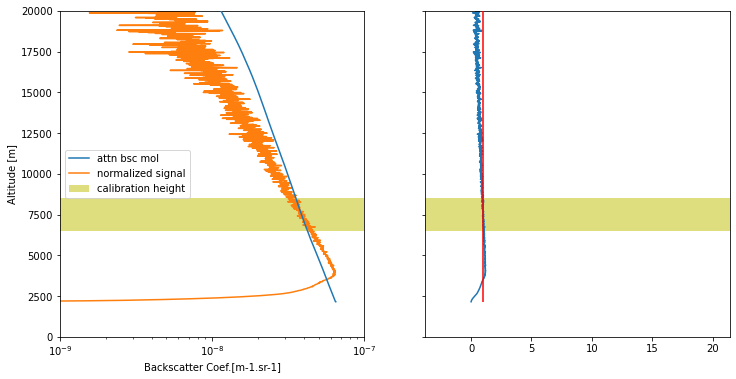

In [380]:

zbottom = 6500
ztop = 8500
Zref, idx_ref = get_altitude_reference(zbottom, ztop, opalt)
t=1
d = oparrcsAV.isel(time = t)['signal'][:len(opalt)]
pres = P_Av.iloc[t,:].values
temp = T_Av.iloc[t,:].values

attn_bscmol, opt_depht= get_attenuation(pres, temp, idx_ref, opalt)
d_norm = normalisation(zbottom, ztop, opalt, d, attn_bscmol)
sr = d_norm/attn_bscmol
print('-------OUTPUT PLOT-------')
fig, (ax,ax2) = plt.subplots(nrows=1, ncols=2, figsize=[12,6], sharey=True)
ax.semilogx(attn_bscmol, opalt, label='attn bsc mol', zorder=10)
ax.semilogx(d_norm[:len(opalt)], opalt, label='normalized signal')
ax.axhspan(zbottom, ztop, color='y', alpha=0.5, lw=0, label='calibration height')
ax.set(xlabel='Backscatter Coef.[m-1.sr-1]', ylabel='Altitude [m]')
ax.legend()
ax.set_ylim(0, 20000)
ax.set_xlim(1e-9, 1e-7)
ax2.plot(sr, opalt) 
ax2.set_ylim(0, 20000)
ax2.vlines(1, ymin=opalt.min(), ymax=opalt.max(), color='r', zorder = 10)
ax2.axhspan(zbottom, ztop, color='y', alpha=0.5, lw=0, label='calibration height')
# plt.savefig('rayleight-fit-'+str(rep1['time'][t].values)+'.png')
# plt.close(fig)
# plt.clf()

### Calculer l'approximation de l'intégrale

In [398]:
import scipy.interpolate as spi

In [399]:
f1 = spi.interp1d(opalt, temp, kind = 'linear', bounds_error=False, fill_value="extrapolate")
temp_appro = f1(z_appro)
# temp_appro = (15+273.15) - 6.5e-3*z_appro

In [400]:
z_appro = np.linspace(15000, 17000, 1000)
const = -(28.966E-3*9.80665)/(8.314510*288.15)
pres_appro = 101325*np.exp(const*z_appro)
k = 1.38e-23
betamol_appro = (pres_appro*1e-2)/(k*temp_appro) * 5.45e-32 * (0.532/0.55)**(-4.09)
alphamol_appro = betamol_appro/0.119
C_appro = 0
for i in range(1000-1):
    C_appro = C_appro + alphamol_appro[i]*(z_appro[i+1]-z_appro[i])

### Créer une fonction pour calculer l'approximation de l'intégrale de tous les points

In [401]:
def get_approximat(z1, z2, interpol_func):
    z_appro = np.linspace(z1, z2, 10000)
    const = -(28.966E-3*9.80665)/(8.314510*288.15)
    pres_appro = 101325*np.exp(const*z_appro)
    temp_appro = interpol_func(z_appro)
    k = 1.38e-23
    betamol_appro = (pres_appro*1e-2)/(k*temp_appro) * 5.45e-32 * (0.532/0.55)**(-4.09)
    alphamol_appro = betamol_appro/0.119
    C_appro = 0
    for i in range(1000-1):
        C_appro = C_appro + alphamol_appro[i]*(z_appro[i+1]-z_appro[i])
    return C_appro


In [402]:
values_appro = [get_approximat(opalt[i], opalt[i+1], f1) for i in range(len(opalt)-1)]
values_appro.append(values_appro[-1])
len(values_appro)

16380

In [397]:
attn_bscmol_appro = bscmol*np.exp(-2*np.array(values_appro))
d_norm_appro = normalisation(8000, 10000, opalt, d, attn_bscmol_appro)

ValueError: operands could not be broadcast together with shapes (3054,) (16380,) 

In [ ]:
print('-------OUTPUT PLOT-------')
fig, (ax,ax2) = plt.subplots(nrows=1, ncols=2, figsize=[12,6], sharey=True)
ax.plot(attn_bscmol, opalt, label='attn bsc mol', zorder=8, color='y')
# ax2 = ax.twiny()
ax.semilogx(attn_bscmol_appro, opalt, label='approximat', zorder=10, color='r')
ax.semilogx(d_norm_appro[:len(opalt)], opalt, label='normalized signal', color='g')
ax.axhspan(zbottom, ztop, color='y', alpha=0.5, lw=0, label='calibration height')
ax.set(xlabel='Backscatter Coef.[m-1.sr-1]', ylabel='Altitude [m]')
ax.legend()
ax.set_ylim(0, 20000)
ax.set_xlim(1e-9, 1e-7)
# ax2.plot(d_norm_appro/attn_bscmol_appro, opalt) 
# ax2.set_ylim(0, 20000)
# ax2.vlines(1, ymin=opalt.min(), ymax=opalt.max(), color='r', zorder = 10)
# ax2.axhspan(zbottom, ztop, color='y', alpha=0.5, lw=0, label='calibration height')
# plt.savefig('rayleight-fit-'+str(rep1['time'][t].values)+'.png')
# plt.close(fig)
# plt.clf()



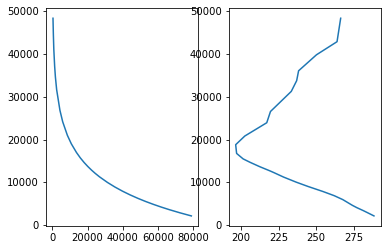

In [408]:
fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2)
ax.plot(pres, opalt, label='origine')
# ax.plot(pres_appro, opalt, label='appro')
ax2.plot(temp, opalt)

In [238]:
del(opt_depht)

### TEST ALPHAMOL et DELTA Z

In [430]:
b = oparsimul['beta355mol'].unstack(level=1).iloc[30,:]

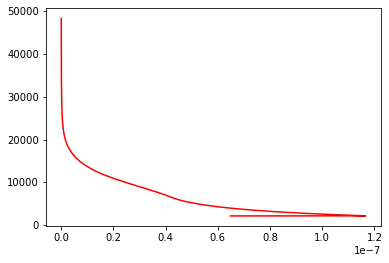

In [432]:

fig, ax = plt.subplots()
ax.plot(attn_bscmol, opalt, label='new', color='r')
ax2 = ax.twiny()
ax2.plot(b, opalt, label='old', color='b')
ax.set_ylim(0, 20000)
